In [8]:
import pymongo as pm #import MongoClient only
import numpy as np
from datetime import datetime, timezone
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import array
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon
client = pm.MongoClient('bigdatadb.polito.it',
ssl=True,
authSource = 'carsharing',
username = 'ictts',
password ='Ict4SM22!',
tlsAllowInvalidCertificates=True)
db = client['carsharing'] #Choose the DB to use
Bookings_collection = db['PermanentBookings'] # Collection for Car2go to use

In [ ]:
import pprint # prettyprinting for json objects

pprint.pprint(Bookings_collection.find_one({"city":"Munchen"}))

In [ ]:
#example of how many booking are there
db['PermanentBookings'].count_documents({"city":"Torino"})
n = db["ActiveBookings"].count_documents({"driving.distance":{"$ne":"-1"}})
print(db.ActiveBookings.find_one(
{ "city": "Torino" } ,
{ "init_time": 1, "final_time": 1, "_id": 0}
))

In [ ]:
#question 1
collections = ["ActiveBookings", "ActiveParkings", "PermanentBookings", "PermanentParkings","enjoy_ActiveBookings",
"enjoy_ActiveParkings","enjoy_PermanentBookings","enjoy_PermanentParkings"]
for i in collections:
    collection = db[i]
    num_documents = collection.count_documents({})
    print(f"Documents for {i} is: {num_documents}")

In [ ]:
#question 2 
#collections = ["ActiveBookings", "ActiveParkings", "PermanentBookings", "PermanentParkings"]
for i in collections:
    collection = db[i]
    cities = collection.distinct("city")
    print(f"Cities in '{i}': {cities}")

In [ ]:
#question 3 
all_cities = set()

# Loop through each collection and collect distinct cities
for i in collections:
    cities_in_collection = db[i].distinct("city")
    all_cities.update(cities_in_collection)

# Convert the set to a sorted list if you want to print it neatly
all_cities = sorted(all_cities)
print(f"Cities for which the system is collecting data: {all_cities}")


In [ ]:
#question 4 
for i in collections:
    collection = db[i]
    
    date = [
        {"$group": {
            "_id": None,
            "start_date": {"$min": "$init_date"},
            "end_date": {"$max": "$final_date"}
        }}
    ]
    
    date_dic = list(collection.aggregate(date)) #creaction of list of initial and final date of collection
    
    # Check if result has data
    if date_dic:
        start_date = date_dic[0]["start_date"]
        end_date = date_dic[0]["end_date"]
        print(f"Collection '{i}': Start Date = {start_date}, End Date = {end_date}")
    else:
        print(f"Collection '{i}' has no date data.")

In [ ]:
#question 5
collections = ["ActiveBookings", "ActiveParkings", "PermanentBookings", "PermanentParkings","enjoy_PermanentBookings","enjoy_PermanentParkings"]

for i in collections:
    collection = db[i]
    info = collection.find_one()
    init_date = info.get("init_date")
    timezone = "UTC" if init_date.tzinfo is None else init_date.tzinfo
    print(f"init_date timezone: {timezone}, for collection {i}")

In [ ]:
'''cities Munchen, Washington DC, Catania (Enjoy)
for enjoy collections: "enjoy_ActiveBookings": Contains cars that are currently booked and not available
 "enjoy_ActiveParkings": Contains cars that are currently parked and available
 ”enjoy_PermanentBookings": Contains all booking periods recorded so far
 "enjoy_PermanentParkings": Contains all parking periods recorded so far'''
pprint.pprint(db["enjoy_PermanentBookings"].find_one({"city":"Catania"}))

In [ ]:
#question 1 
from datetime import datetime, timedelta
cities = ["Munchen","Washington DC", "Catania"]

num_cars = {}
city = db["PermanentBookings"].distinct("vin",{"city":"Munchen"})
num_cars["Munchen"]=len(city)
city = db["PermanentBookings"].distinct("vin",{"city":"Washington DC"})
num_cars["Washington DC"]=len(city)
city = db["enjoy_PermanentBookings"].distinct("virtual_rental_id",{"city":"Catania"})
num_cars["Catania"]=len(city)

for city in num_cars:
    print(f"Number of seen cars for {city} --> {num_cars[city]}")

# Define the date range (one week)
start_date_B = datetime(2018, 9, 27, 17, 10, 42)  # Replace with desired start date for Bologna
end_date_B = start_date_B + timedelta(weeks=1)
start_date = datetime(2016, 12, 13, 18, 40, 42)# for Munchen and Washington DC
end_date = start_date + timedelta(weeks=1)

fleet = {}
unique_cars = db["PermanentBookings"].distinct(
        "vin", 
        {"city": "Munchen", "init_date": {"$gte": start_date, "$lt": end_date}}
    )
fleet["Munchen"] = len(unique_cars)
unique_cars = db["PermanentBookings"].distinct(
        "vin", 
        {"city": "Washington DC", "init_date": {"$gte": start_date, "$lt": end_date}}
    )
fleet["Washington DC"] = len(unique_cars)
unique_cars = db["enjoy_PermanentBookings"].distinct(
        "virtual_rental_id", 
        {"city": "Catania", "init_date": {"$gte": start_date_B, "$lt": end_date_B}}
    )
fleet["Catania"] = len(unique_cars)
for city in fleet:
    print(f"fleet size cars for {city} --> {fleet[city]}")


num_cars = {"Munchen": num_cars["Munchen"], "Washington DC": num_cars["Washington DC"], "Catania": num_cars["Catania"]}
fleet = {"Munchen": fleet["Munchen"], "Washington DC": fleet["Washington DC"], "Catania": fleet["Catania"]}

for i in cities:
    total_cars = num_cars[i]  # Total cars over the entire period
    weekly_fleet_size = fleet[i]   # Weekly estimated fleet size
    percentage_active = (weekly_fleet_size / total_cars) * 100 if total_cars > 0 else 0
    print(f"In {i}, approximately {percentage_active:.2f}")

In [ ]:
#question 2


#period
start_date = datetime(2017, 12, 1)
end_date = datetime(2018, 1, 1)

count = 0
bookings_per_city = {}
for i in cities:
    if i == "Catania":
        count = db["enjoy_PermanentBookings"].count_documents({
        "city": i,
        "init_date": {"$gte": start_date, "$lt": end_date}
    })
    else:
        bookings_per_city[i] = count
        count = db["PermanentBookings"].count_documents({
            "city": i,
            "init_date": {"$gte": start_date, "$lt": end_date}
        })
        bookings_per_city[i] = count
    print(f"Number of bookings in December 2017 for {i}: {count}")

In [ ]:
#question 3 
cities = ["Munchen","Washington DC", "Catania"] #for our cities, 0 as public transports is correct because we have info 
                                                # from external sources just for torino and milano
public_transport={}
for i in cities:
    if i == "Catania":
        p_transport = db["enjoy_PermanentBookings"].count_documents({
        "city": i,
        "public_transport.distance": {"$ne": -1}, # {"$ne": -1}: Ensures that the duration is also recorded (not equal to -1).
        "public_transport.duration": {"$ne": -1}
        })
        public_transport[i]=p_transport
    else:
        p_transport = db["enjoy_PermanentBookings"].count_documents({
        "city": i,
        "public_transport.distance": {"$ne": -1},
        "public_transport.duration": {"$ne": -1}
        })
        public_transport[i]=p_transport
    print(f"Number of public transport taken in {i} are: {public_transport[i]}")

In [2]:
#Step 2
#A  time of November 1st 2017 – January 31st 2018
from datetime import datetime, timedelta
import array
import numpy as np
cities = ["Munchen","Washington DC", "Catania"]

booking = []
parking = []
booking_duration = []
parking_duration = []

start_date = datetime(2017, 11, 1)
end_date = datetime(2018, 1, 31)

for idx,i in enumerate(cities):
    print(i)
    booking_duration.append([])
    parking_duration.append([])
    if i == "Catania":
        for doc in db["enjoy_PermanentBookings"].find({"city": i,
        "init_date": {"$gte": start_date, "$lt": end_date}}):
            booking_duration[idx].append(doc["final_time"]- doc["init_time"])
        
        for doc in db["enjoy_PermanentParkings"].find({"city": i,
        "init_date": {"$gte": start_date, "$lt": end_date}}):
            parking_duration[idx].append(doc["final_time"]- doc["init_time"])
    else:
        for doc in db["PermanentBookings"].find({"city": i,
        "init_date": {"$gte": start_date, "$lt": end_date}}):
            booking_duration[idx].append(doc["final_time"]- doc["init_time"])
        for doc in db["PermanentParkings"].find({"city": i,
        "init_date": {"$gte": start_date, "$lt": end_date}}):
            parking_duration[idx].append(doc["final_time"]- doc["init_time"])




Munchen
Washington DC
Catania


c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


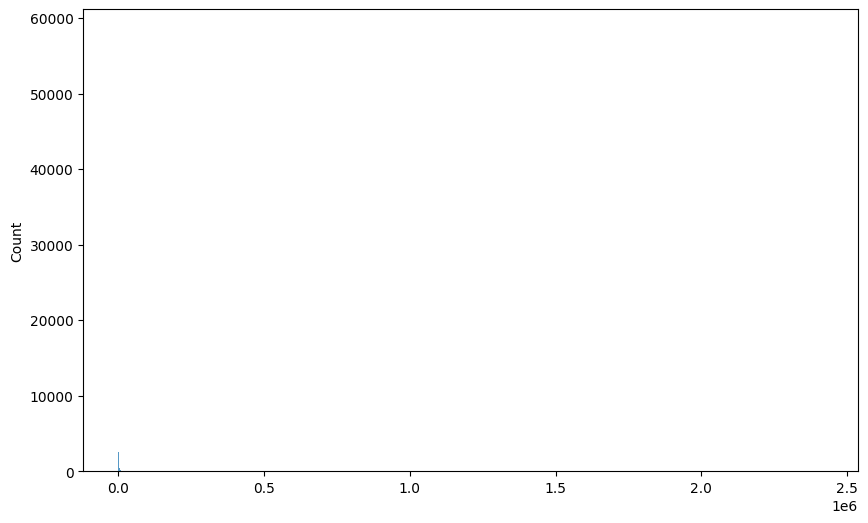

In [3]:
import seaborn as sns

a = np.array(booking_duration[0])
plt.figure(figsize=(10,6))
sns.histplot(a)
plt.show()

c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


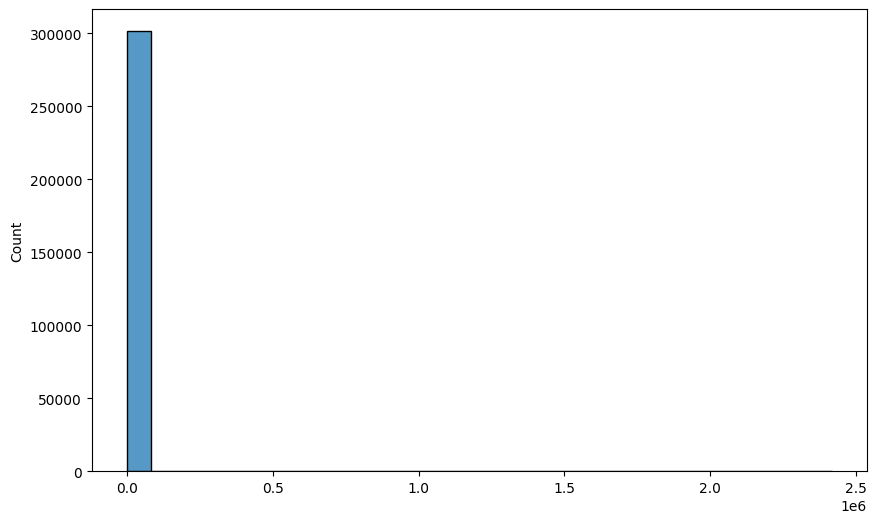

In [4]:
a = np.array(booking_duration[0])
plt.figure(figsize=(10,6))
sns.histplot(a, bins= 30)
plt.show()

c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\nepim\App

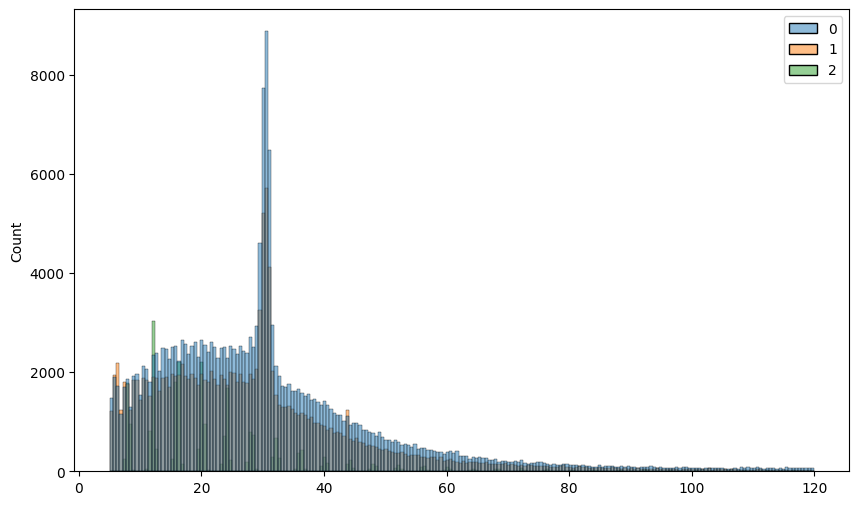

In [5]:
booking_durations_np = []
filtered_bookings = []
sorted_durations = []
for i in range(3):
    booking_durations_np.append(np.array(booking_duration[i]))
    booking_durations_np[i] = booking_durations_np[i] / 60
    filtered_bookings.append(booking_durations_np[i][(booking_durations_np[i] < 120) & (booking_durations_np[i] > 5)])
    sorted_durations.append(np.sort(filtered_bookings[i]))


plt.figure(figsize=(10,6))
sns.histplot(filtered_bookings)
plt.show()

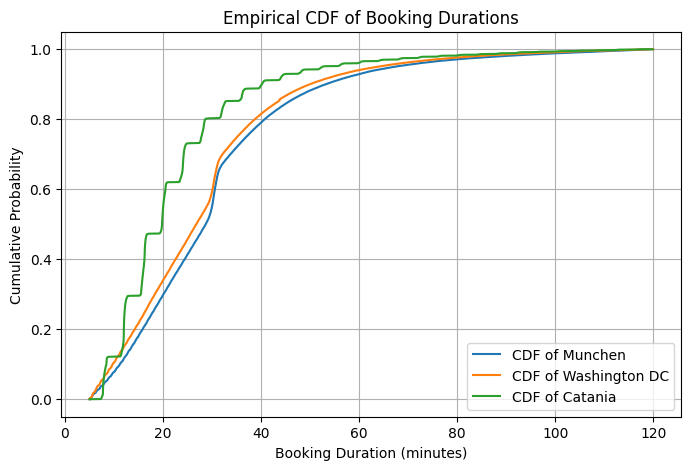

In [6]:


n = []
cumulative_probabilities = []
# Step 2: Calculate cumulative probabilities
for i in range(3):
    n.append(len(sorted_durations[i]))
    cumulative_probabilities.append(np.arange(1, n[i] + 1) / n[i])

# Step 3: Plot the empirical CDF
plt.figure(figsize=(8, 5))
for idx, i in enumerate(cities):
    plt.plot(sorted_durations[idx], cumulative_probabilities[idx], label=f"CDF of {i}")


# Labels and Title
plt.xlabel("Booking Duration (minutes)")
plt.ylabel("Cumulative Probability")
plt.title("Empirical CDF of Booking Durations")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
for i in range(3):
    print(len(sorted_durations[i]))

201777
150084
24910


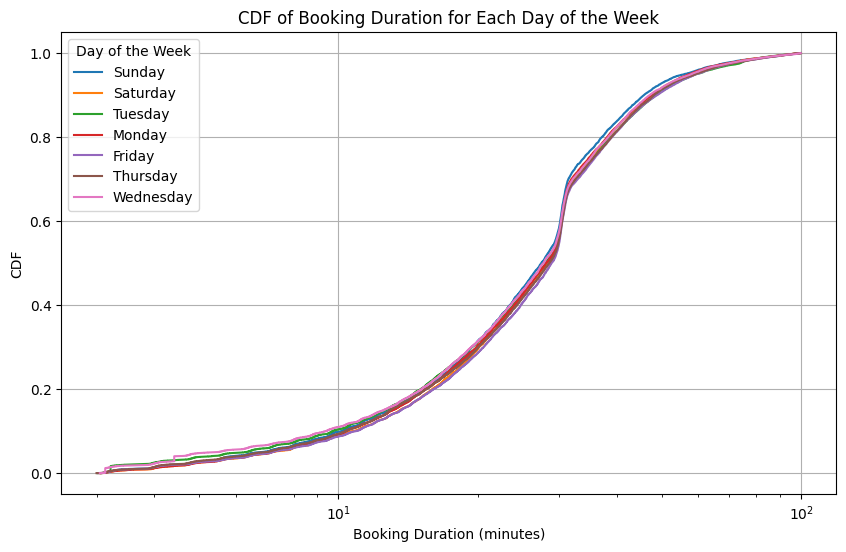

In [8]:

start_date = datetime(2017, 11, 1)
end_date = datetime(2018, 1, 31)
city = "Amsterdam"

pipeline = [
    # Step 1: Calculate the duration in minutes
    {
        "$match": {
            "city": city,
            "init_date": {
                "$gte": start_date,  # Greater than or equal to start_date
                "$lte": end_date  # Less than or equal to end_date
            }
        }
    },
    {
        "$addFields": {
            "duration_minutes": {
                "$divide": [
                    { "$subtract": ["$final_time", "$init_time"] },
                    60  # Convert milliseconds to minutes
                ]
            }
        }
    },
    {
    "$match": {
        "duration_minutes": {
            "$gte": 3,
            "$lte": 100
            }
        }
    },
    # Step 2: Extract day of the week from init_time
    {
        "$addFields": {
            "day_of_week": { "$dayOfWeek": "$init_date" }
        }
    },
    # Step 3: Group by day of the week, accumulating all durations in arrays
    {
        "$group": {
            "_id": "$day_of_week",
            "durations": { "$push": "$duration_minutes" }
        }
    }
]



results = list(db["PermanentBookings"].aggregate(pipeline))


# Map MongoDB day_of_week values to readable day names
day_map = {1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 5: 'Thursday', 6: 'Friday', 7: 'Saturday'}

# Prepare to plot CDF for each day of the week
plt.figure(figsize=(10, 6))

for result in results:
    day_name = day_map[result["_id"]]
    durations = sorted(result["durations"])
    
    # Calculate the CDF values
    cdf_values = np.arange(1, len(durations) + 1) / len(durations)
    
    # Plot the CDF for this day
    plt.plot(durations, cdf_values, label=day_name)

# Set plot labels and legend
plt.xlabel("Booking Duration (minutes)")
plt.ylabel("CDF")
plt.title("CDF of Booking Duration for Each Day of the Week")
plt.legend(title="Day of the Week")
plt.semilogx()
plt.grid(True)
plt.show()

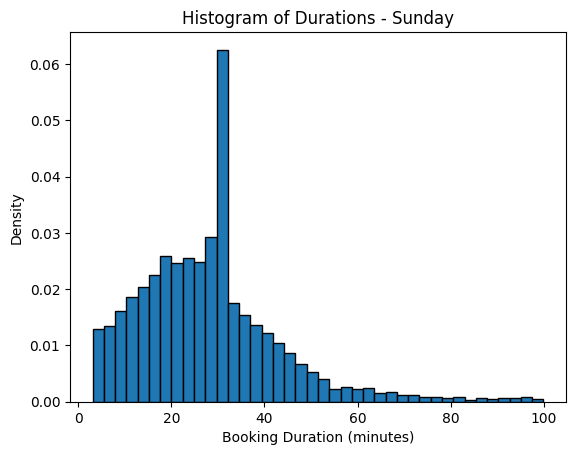

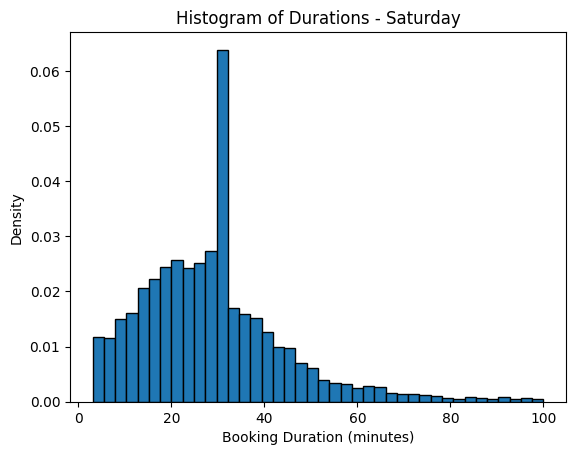

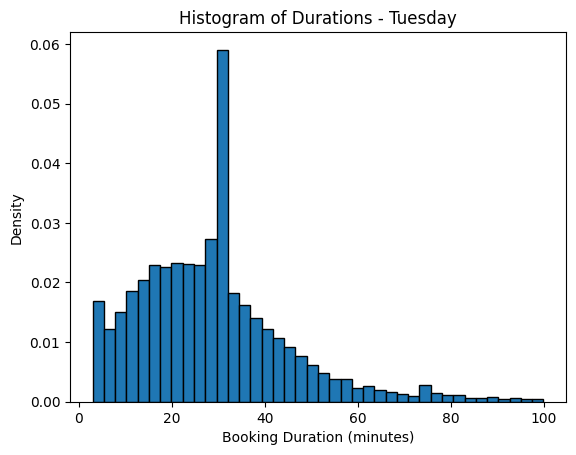

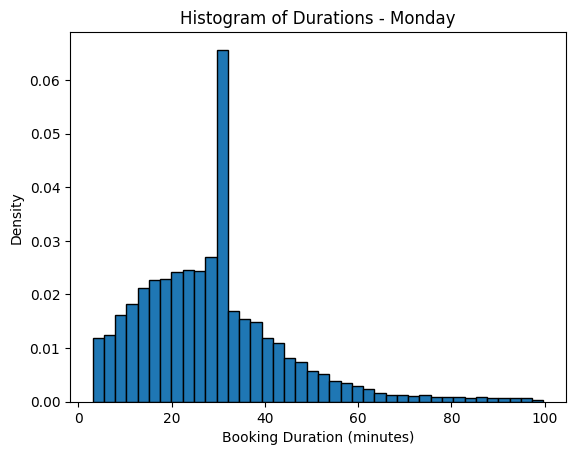

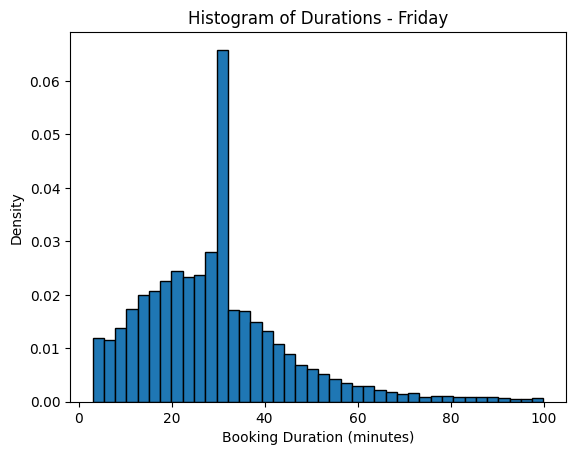

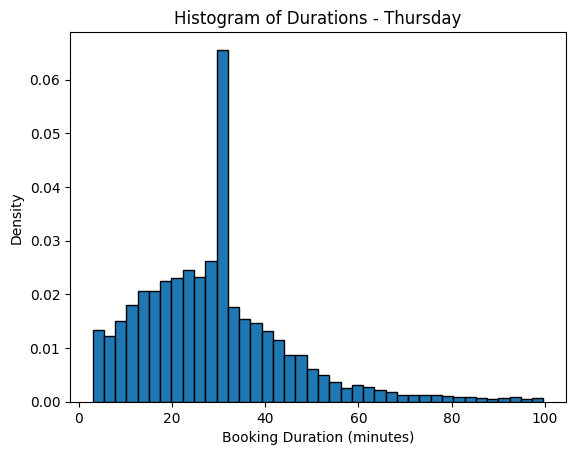

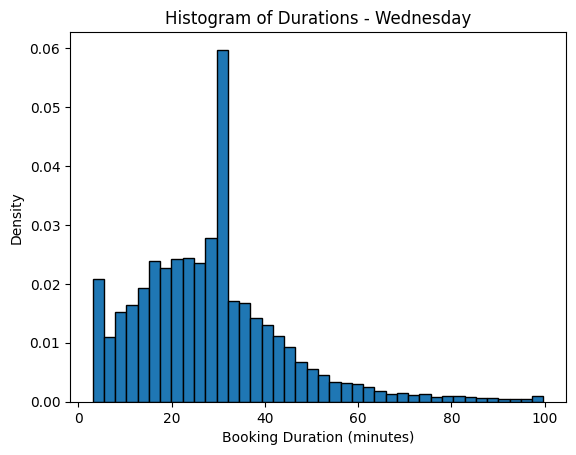

In [9]:
# Number of bins for the histogram
num_bins = 40

# Plot histograms for each day of the week in subplots
for idx, result in enumerate(results):
    day_name = day_map[result["_id"]]
    durations = result["durations"]
    plt.figure()
    # Plot histogram for the current day's data
    plt.hist(durations, bins=num_bins, edgecolor='black', density=True)
    plt.title(f"Histogram of Durations - {day_name}")
    plt.xlabel("Booking Duration (minutes)")
    plt.ylabel("Density")
    plt.show()



# Show the plot


In [10]:
for result in results:
    a = result
    print(np.average(result["durations"]))

27.939318222380866
28.774169207653898
28.659719578733664
28.5158010603965
29.252098140786252
28.89223923001102
28.22450529265845


[30.05, 43.983333333333334, 21.75, 25.233333333333334, 21.75, 23.483333333333334, 13.716666666666667, 17.233333333333334, 15.266666666666667, 43.93333333333333, 11.766666666666667, 18.75, 16.983333333333334, 25.616666666666667, 32.11666666666667, 37.266666666666666, 20.3, 16.766666666666666, 32.8, 22.35, 23.3, 24.216666666666665, 23.366666666666667, 22.416666666666668, 31.083333333333332, 21.633333333333333, 12.35, 16.95, 13.216666666666667, 6.8, 5.733333333333333, 19.683333333333334, 10.233333333333333, 8.583333333333334, 11.183333333333334, 27.033333333333335, 38.15, 24.466666666666665, 30.916666666666668, 10.2, 17.8, 10.166666666666666, 11.033333333333333, 19.05, 21.8, 35.56666666666667, 31.016666666666666, 7.3, 11.733333333333333, 12.566666666666666, 18.183333333333334, 11.133333333333333, 29.883333333333333, 29.783333333333335, 38.43333333333333, 12.233333333333333, 4.383333333333334, 45.68333333333333, 33.766666666666666, 22.633333333333333, 17.85, 30.1, 30.066666666666666, 46.96

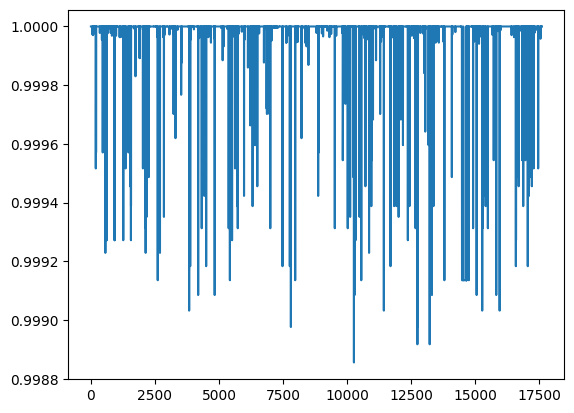

In [11]:
import scipy
import scipy.stats
import seaborn as sns
print(result["durations"])
cdf = scipy.stats.norm.cdf(result["durations"])
plt.plot(cdf)
plt.show()

In [ ]:
def ut_hour_day(title, Bookings, Parkings):
    listBookings = list(Bookings)
    DFBookings = pd.DataFrame(listBookings)
    listParkings = list(Parkings)
    DFParkings = pd.DataFrame(listParkings)
    labels = []
    ticks = []
    
    if DFBookings.empty or DFParkings.empty:
        print(f"No data available for {title}")
        return
    


    for i in range(DFBookings.shape[0]):
        if i == (DFBookings.shape[0] - 1):
            break
        elif (DFBookings["_id"][i]["hour"] == 0) or ((DFBookings["_id"][i + 1]["dow"] - DFBookings["_id"][i]["dow"]) != 0) and ((DFBookings["_id"][i + 1]["dow"] - DFBookings["_id"][i]["dow"]) != 1):
            ticks.append(i)
            formatted_date = day_of_year_to_date(DFBookings["_id"][i + 1]["dow"], 2017)
            labels.append(formatted_date)

    print("DFBookings Columns:", DFBookings.columns)
    print("DFParkings Columns:", DFParkings.columns)

    print("DFBookings Shape:", DFBookings.shape)
    print("DFParkings Shape:", DFParkings.shape)
    plt.figure()
    plt.xlabel("Days of December")
    plt.ylabel("N. of Bookings/parkings")
    plt.title(title)
    plt.plot(DFBookings["PermanentBookings"], label="Bookings")
    plt.plot(DFParkings["PermanentParkings"], label="Parkings")
    plt.xticks(ticks=ticks, labels=labels)
    plt.legend(loc='best')
    plt.grid(True, which="both")
    plt.show()

DFBookings Columns: Index(['_id', 'PermanentBookings'], dtype='object')
DFParkings Columns: Index(['_id', 'PermanentParkings'], dtype='object')
DFBookings Shape: (690, 2)
DFParkings Shape: (690, 2)


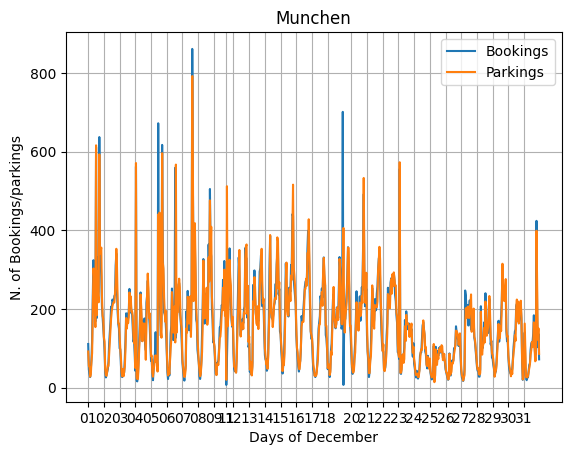

DFBookings Columns: Index(['_id', 'PermanentBookings'], dtype='object')
DFParkings Columns: Index(['_id', 'PermanentParkings'], dtype='object')
DFBookings Shape: (700, 2)
DFParkings Shape: (701, 2)


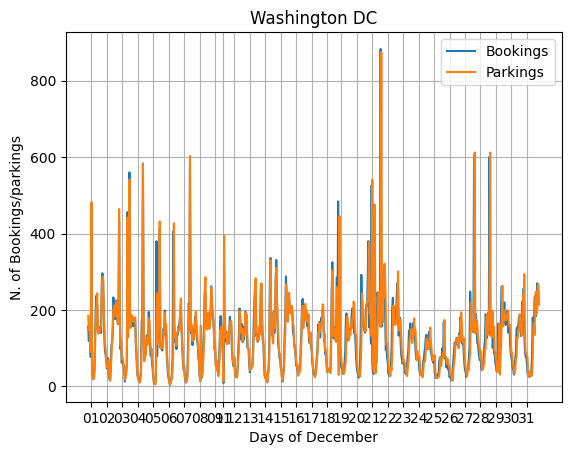

DFBookings Columns: Index(['_id', 'PermanentBookings'], dtype='object')
DFParkings Columns: Index(['_id', 'PermanentParkings'], dtype='object')
DFBookings Shape: (697, 2)
DFParkings Shape: (696, 2)


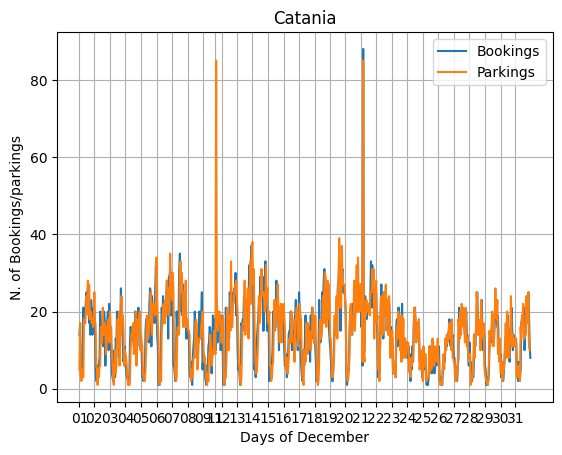

In [25]:
import pandas as pd
date_init = datetime.strptime('2017-12-01T00:00:00', '%Y-%m-%dT%H:%M:%S')
# date_init_Denver = datetime.strptime('2017-12-01T07:00:00', '%Y-%m-%dT%H:%M:%S')
date_finish = datetime.strptime('2017-12-31T23:59:59', '%Y-%m-%dT%H:%M:%S')
# date_finish_Denver = datetime.strptime('2017-12-31T17:59:59', '%Y-%m-%dT%H:%M:%S')
init_unix = (date_init - datetime(1970, 1, 1)).total_seconds()
finish_unix = (date_finish - datetime(1970, 1, 1)).total_seconds()
Bookings = db["PermanentBookings"]
Parkings = db["PermanentParkings"]
cities = ["Munchen", "Washington DC", "Catania"]
Hour_Day_Aggregation = {}
for city in cities:
    if city == "Catania":
        Bookings = db["enjoy_PermanentBookings"]
        Parkings = db["enjoy_PermanentParkings"]
    Hour_Day_Aggregation['Bookings{0}'.format(city)] =Bookings.aggregate([
        {"$match": {
            "city": city,
            "init_time": {"$gte": init_unix, "$lte": finish_unix}
        }},
        {"$project": {
            "dow": {"$dayOfYear": "$init_date"},
            "hour": {"$hour": "$init_date"}
        }},
        {"$group": {
            "_id": {"dow": "$dow", "hour": "$hour"},
            "PermanentBookings": {"$sum": 1}
        }},
        {"$sort": {
            "_id": 1
        }}
    ])

    Hour_Day_Aggregation['Parkings{0}'.format(city)] = Parkings.aggregate([
        {"$match": {
            "city": city,
            "init_time": {"$gte": init_unix, "$lte": finish_unix}
        }},
        {"$project": {
            "dow": {"$dayOfYear": "$init_date"},
            "hour": {"$hour": "$init_date"},
            "data": "$init_date"
        }},
        {"$group": {
            "_id": {"dow": "$dow", "hour": "$hour"},
            "PermanentParkings": {"$sum": 1}
        }},
        {"$sort": {
            "_id": 1
        }}
    ])

    ut_hour_day(city, Hour_Day_Aggregation['Bookings' + city], Hour_Day_Aggregation['Parkings' + city])


In [ ]:
#question 6

public =list(db["enjoy_PermanentBookings"].find({"city": "Milano",
"public_transport.distance": {"$ne": -1}, # {"$ne": -1}: Ensures that the duration is also recorded (not equal to -1).
"public_transport.duration": {"$ne": -1},
"public_transport.arrival_time":{"$ne": -1} 
})) 

print(f"Numer of rentals: {len(public)}")

for doc in public[:5]:
    print(doc)

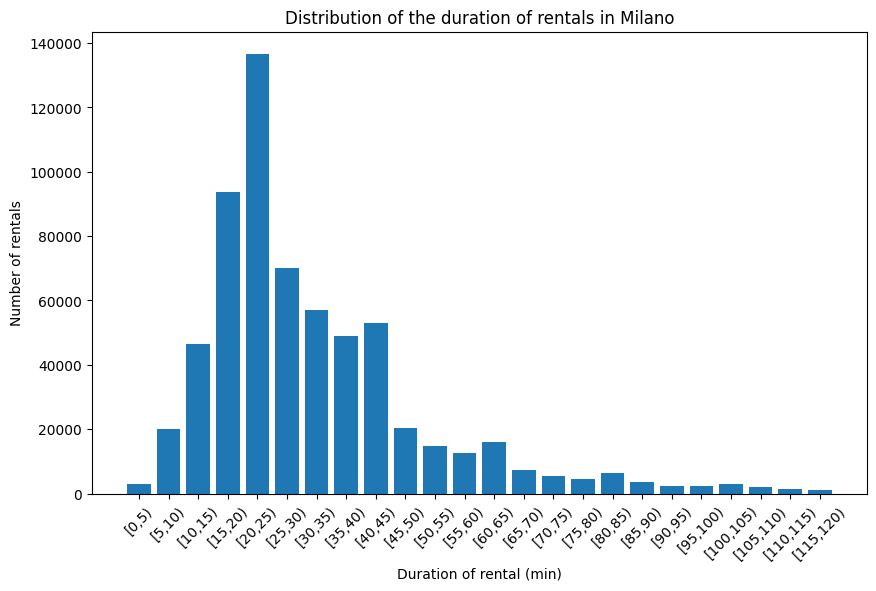

In [3]:



time_bins = np.arange(0, 125, 5).tolist() 
pipeline = [
    {"$match": {
        "city": "Milano",
        "public_transport.distance": {"$ne": -1}, 
        "public_transport.duration": {"$ne": -1},
        "public_transport.arrival_time":{"$ne": -1},
        "$expr": {
            "$ne": [
                {"$arrayElemAt": ["$origin_destination.coordinates", 0]},  # Filter to see if the position change
                {"$arrayElemAt": ["$origin_destination.coordinates", 1]}   
            ]
        }
    }},
    
    {"$project": {
        "duration_minutes": {
            "$divide": [
                {"$subtract": ["$final_time", "$init_time"]},
                60
            ]
        }
    }},
    
    #  divide the each rental for its durations (bins)
    {"$bucket": {
        "groupBy": "$duration_minutes",
        "boundaries": time_bins,
        "default": "Out of range",  #values> 100 min
        "output": {
            "count": {"$sum": 1}  # count number of documents
        }
    }}
]


public_t = list(db["enjoy_PermanentBookings"].aggregate(pipeline))

durations = [p["_id"] for p in public_t if p["_id"]!= "Out of range"]
rentals = [p["count"] for p in public_t if p["_id"]!= "Out of range"]
plt.figure(figsize=(10, 6))
plt.bar(durations, rentals, width=4)
plt.xlabel("Duration of rental (min)")
plt.ylabel("Number of rentals")
plt.title("Distribution of the duration of rentals in Milano")
plt.xticks(ticks=durations, labels=[f"[{d},{d+5})" for d in durations], rotation=45)# used to aggregate the intervals in (0,5) - (5,1)..
plt.show()

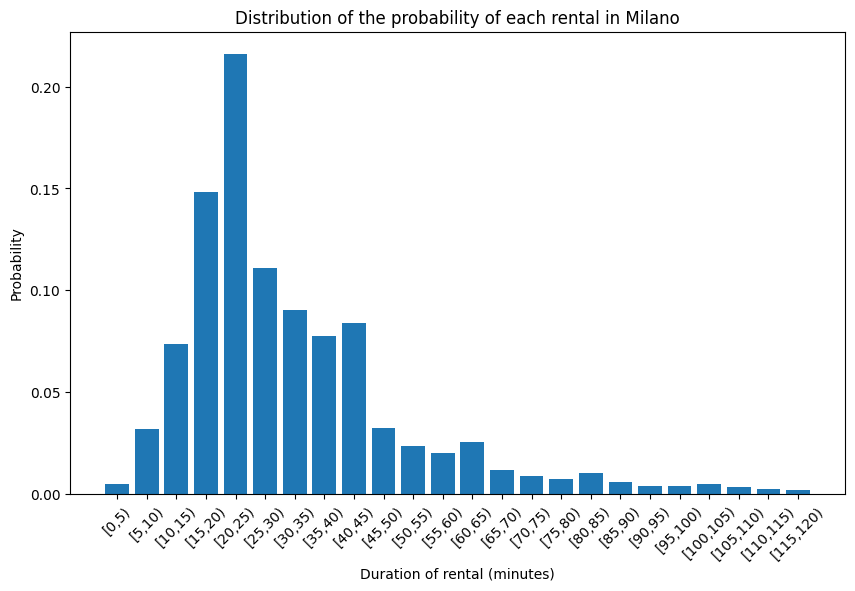

In [4]:
total_rentals = sum(rentals)
prob=[]
for i in rentals:
    prob.append(i/total_rentals)

plt.figure(figsize=(10, 6))
plt.bar(durations, prob, width=4)
plt.xlabel("Duration of rental (minutes)")
plt.ylabel("Probability")
plt.title("Distribution of the probability of each rental in Milano")
plt.xticks(ticks=durations, labels=[f"[{d},{d+5})" for d in durations], rotation=45)# used to aggregate the intervals in (0,5) - (5,1)..
plt.show()

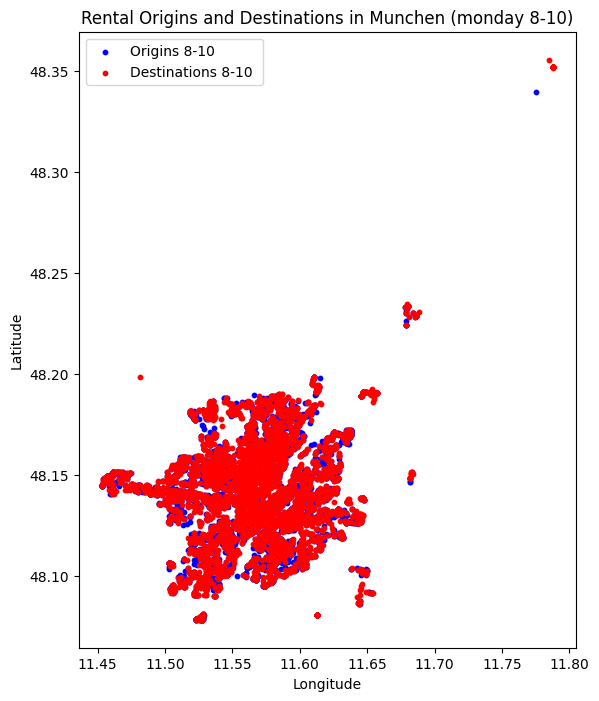

In [5]:
#7
#a
days = ["Sunday","monday","thuesday","wednesday","thursday","friday","saturday"]
pipeline = [
    {"$match": {
        "city": "Munchen" 
    }},
    {"$addFields": {
        "init_day": {"$dayOfWeek": "$init_date"},
        "init_hour": {"$hour": "$init_date"},
        "final_hour": {"$hour": "$final_date"}
    }},
    {"$match": {
        "init_day": 1,  # Monday change here to see different distribution
        "$or": [
            {"init_hour": {"$gte": 8, "$lt": 10}},  # 8-10 
            {"init_hour": {"$gte": 18, "$lt": 20}}  # 18-20
        ]
    }},
    {"$project": {
        "init_coords": {"$arrayElemAt": ["$origin_destination.coordinates", 0]},
        "final_coords": {"$arrayElemAt": ["$origin_destination.coordinates", 1]},
        "init_date": 1,
        "final_date": 1
    }}
]

# Execute the pipeline
data = list(db["PermanentBookings"].aggregate(pipeline))

coords_8_10 = {"origins": [], "destinations": []}
coords_18_20 = {"origins": [], "destinations": []}

# Organize data by time of day
for i in data:
    init_hour = i["init_date"].hour
    if 8 <= init_hour < 10:
        coords_8_10["origins"].append(i["init_coords"])
        coords_8_10["destinations"].append(i["final_coords"])
    elif 18 <= init_hour < 20:
        coords_18_20["origins"].append(i["init_coords"])
        coords_18_20["destinations"].append(i["final_coords"])

# Create GeoDataFrames
origins_x_8_10 = [coord[0] for coord in coords_8_10["origins"]]
origins_y_8_10 = [coord[1] for coord in coords_8_10["origins"]]
destinations_x_8_10 = [coord[0] for coord in coords_8_10["destinations"]]
destinations_y_8_10 = [coord[1] for coord in coords_8_10["destinations"]]

origins_x_18_20 = [coord[0] for coord in coords_18_20["origins"]]
origins_y_18_20 = [coord[1] for coord in coords_18_20["origins"]]
destinations_x_18_20 = [coord[0] for coord in coords_18_20["destinations"]]
destinations_y_18_20 = [coord[1] for coord in coords_18_20["destinations"]]

# Create GeoDataFrames
origins_gdf_8_10 = gpd.GeoDataFrame(geometry=gpd.points_from_xy(origins_x_8_10, origins_y_8_10), crs="EPSG:4326")
destinations_gdf_8_10 = gpd.GeoDataFrame(geometry=gpd.points_from_xy(destinations_x_8_10, destinations_y_8_10), crs="EPSG:4326")

origins_gdf_18_20 = gpd.GeoDataFrame(geometry=gpd.points_from_xy(origins_x_18_20, origins_y_18_20), crs="EPSG:4326")
destinations_gdf_18_20 = gpd.GeoDataFrame(geometry=gpd.points_from_xy(destinations_x_18_20, destinations_y_18_20), crs="EPSG:4326")

# Plot the data
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

origins_gdf_8_10.plot(ax=ax, color="blue", marker="o", label="Origins 8-10 ", markersize=10)
destinations_gdf_8_10.plot(ax=ax, color="red", marker="o", label="Destinations 8-10 ", markersize=10)
plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Rental Origins and Destinations in Munchen ({days[1]} 8-10)")
plt.show()

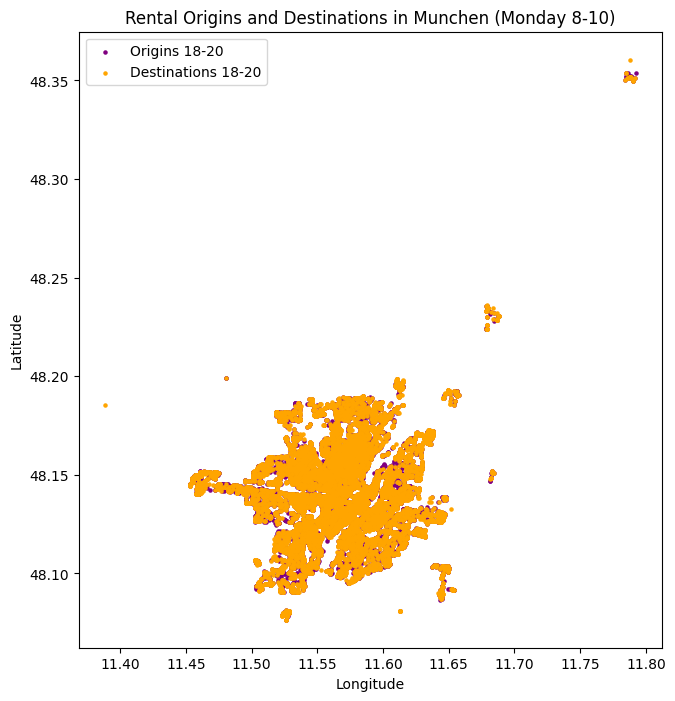

In [6]:
#for 18-20 

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

origins_gdf_18_20.plot(ax=ax, color="purple", marker="o", label="Origins 18-20 ", markersize=5)
destinations_gdf_18_20.plot(ax=ax, color="orange", marker="o", label="Destinations 18-20", markersize=5)
plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Rental Origins and Destinations in Munchen (Monday 8-10)")
plt.show()

In [9]:
#7b
import math
import numpy as np

# coordinates
min_lon = min(origins_gdf_8_10.geometry.x.min(), destinations_gdf_8_10.geometry.x.min())
max_lon = max(origins_gdf_8_10.geometry.x.max(), destinations_gdf_8_10.geometry.x.max())
min_lat = min(origins_gdf_8_10.geometry.y.min(), destinations_gdf_8_10.geometry.y.min())
max_lat = max(origins_gdf_8_10.geometry.y.max(), destinations_gdf_8_10.geometry.y.max())

# definition rectangle
bottomLeft, bottomRight = (min_lat, min_lon), (min_lat, max_lon)
topLeft, topRight = (max_lat, min_lon), (max_lat, max_lon)


# zones
Number_zones_total = 500
x = int(math.sqrt(Number_zones_total)) + 1
cols = np.linspace(bottomLeft[1], bottomRight[1], num=x)
rows = np.linspace(bottomLeft[0], topLeft[0], num=x)

# assign origins and destitations the zones
origins_gdf_8_10['col'] = np.searchsorted(cols, origins_gdf_8_10.geometry.x)
origins_gdf_8_10['row'] = np.searchsorted(rows, origins_gdf_8_10.geometry.y)
origins_gdf_8_10['zone_id'] = origins_gdf_8_10['row'].astype(str) + origins_gdf_8_10['col'].astype(str)

destinations_gdf_8_10['col'] = np.searchsorted(cols, destinations_gdf_8_10.geometry.x)
destinations_gdf_8_10['row'] = np.searchsorted(rows, destinations_gdf_8_10.geometry.y)
destinations_gdf_8_10['zone_id'] = destinations_gdf_8_10['row'].astype(str) + destinations_gdf_8_10['col'].astype(str)
#zone
res_origin = origins_gdf_8_10.groupby(['row', 'col', 'zone_id']).size().reset_index(name='count_origin')
sum_origin = res_origin["count_origin"].sum()
res_origin["prob_origin"] = res_origin["count_origin"] / sum_origin

res_dest = destinations_gdf_8_10.groupby(['row', 'col', 'zone_id']).size().reset_index(name='count_destination')
sum_destination = res_dest["count_destination"].sum()
res_dest["prob_destination"] = res_dest["count_destination"] / sum_destination

# dataframe 
trip_generation = res_origin.merge(res_dest, on=['row', 'col', 'zone_id'], how='outer').fillna(0)

# limit 
trip_generation["lon_min"] = cols[trip_generation["col"] - 1]
trip_generation["lon_max"] = cols[trip_generation["col"]]
trip_generation["lat_min"] = rows[trip_generation["row"] - 1]
trip_generation["lat_max"] = rows[trip_generation["row"]]

# poligons
trip_generation['geometry'] = trip_generation.apply(
    lambda row: Polygon([
        (row.lon_min, row.lat_min),
        (row.lon_max, row.lat_min),
        (row.lon_max, row.lat_max),
        (row.lon_min, row.lat_max)
    ]),
    axis=1
)


gdf_gen = gpd.GeoDataFrame(trip_generation, geometry="geometry", crs="EPSG:4326")

gdf_gen_origin_8_10 = gdf_gen[['geometry', 'prob_origin']].copy()
gdf_gen_origin_8_10.explore(
    column='prob_origin',
    cmap='cividis',
    tooltip='prob_origin',
    legend=True,
    legend_kwds={'caption': 'Origins 8-10'}
)





In [10]:
gdf_gen_destinations_8_10 = gdf_gen[['geometry', 'prob_destination']].copy()
gdf_gen_destinations_8_10.explore(
    column='prob_destination',
    cmap='cividis',
    tooltip='prob_destination',
    legend=True,
    legend_kwds={'caption': 'Destinations 8-10'}
)

In [11]:
# coordinates
min_lon = min(origins_gdf_18_20.geometry.x.min(), destinations_gdf_18_20.geometry.x.min())
max_lon = max(origins_gdf_18_20.geometry.x.max(), destinations_gdf_18_20.geometry.x.max())
min_lat = min(origins_gdf_18_20.geometry.y.min(), destinations_gdf_18_20.geometry.y.min())
max_lat = max(origins_gdf_18_20.geometry.y.max(), destinations_gdf_18_20.geometry.y.max())

# definition rectangle
bottomLeft, bottomRight = (min_lat, min_lon), (min_lat, max_lon)
topLeft, topRight = (max_lat, min_lon), (max_lat, max_lon)


# zones
Number_zones_total = 500
x = int(math.sqrt(Number_zones_total)) + 1
cols = np.linspace(bottomLeft[1], bottomRight[1], num=x)
rows = np.linspace(bottomLeft[0], topLeft[0], num=x)

# assign origins and destitations the zones
origins_gdf_18_20['col'] = np.searchsorted(cols, origins_gdf_18_20.geometry.x)
origins_gdf_18_20['row'] = np.searchsorted(rows, origins_gdf_18_20.geometry.y)
origins_gdf_18_20['zone_id'] = origins_gdf_18_20['row'].astype(str) + origins_gdf_18_20['col'].astype(str)

destinations_gdf_18_20['col'] = np.searchsorted(cols, destinations_gdf_18_20.geometry.x)
destinations_gdf_18_20['row'] = np.searchsorted(rows, destinations_gdf_18_20.geometry.y)
destinations_gdf_18_20['zone_id'] = destinations_gdf_18_20['row'].astype(str) + destinations_gdf_18_20['col'].astype(str)
#zone
res_origin = origins_gdf_18_20.groupby(['row', 'col', 'zone_id']).size().reset_index(name='count_origin')
sum_origin = res_origin["count_origin"].sum()
res_origin["prob_origin"] = res_origin["count_origin"] / sum_origin

res_dest = destinations_gdf_18_20.groupby(['row', 'col', 'zone_id']).size().reset_index(name='count_destination')
sum_destination = res_dest["count_destination"].sum()
res_dest["prob_destination"] = res_dest["count_destination"] / sum_destination

# dataframe 
trip_generation = res_origin.merge(res_dest, on=['row', 'col', 'zone_id'], how='outer').fillna(0)

# limit 
trip_generation["lon_min"] = cols[trip_generation["col"] - 1]
trip_generation["lon_max"] = cols[trip_generation["col"]]
trip_generation["lat_min"] = rows[trip_generation["row"] - 1]
trip_generation["lat_max"] = rows[trip_generation["row"]]

# poligons
trip_generation['geometry'] = trip_generation.apply(
    lambda row: Polygon([
        (row.lon_min, row.lat_min),
        (row.lon_max, row.lat_min),
        (row.lon_max, row.lat_max),
        (row.lon_min, row.lat_max)
    ]),
    axis=1
)

gdf_gen = gpd.GeoDataFrame(trip_generation, geometry="geometry", crs="EPSG:4326")

gdf_gen_origin_18_20 = gdf_gen[['geometry', 'prob_origin']].copy()
gdf_gen_origin_18_20.explore(
    column='prob_origin',
    cmap='cividis',
    tooltip='prob_origin',
    legend=True,
    legend_kwds={'caption': 'Origins 18-20'}
)


In [12]:
gdf_gen_origin_18_20 = gdf_gen[['geometry', 'prob_destination']].copy()
gdf_gen_origin_18_20.explore(
    column='prob_destination',
    cmap='cividis',
    tooltip='prob_destination',
    legend=True,
    legend_kwds={'caption': 'Destinations 18-20'}
)